In [1]:
import functools
import pandas as pd
import numpy as np

import matplotlib.pyplot as plt
import seaborn as sns
import lightgbm as lgb
import torch
from torch import nn
from torch.utils.data import DataLoader
from sklearn.linear_model import RidgeCV, LassoCV, Ridge, Lasso
from sklearn.model_selection import train_test_split as _train_test_split
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import mean_squared_error
from sklearn.preprocessing import StandardScaler, PolynomialFeatures, FunctionTransformer
from sklearn.pipeline import Pipeline, FeatureUnion, make_union
from sklearn.metrics import make_scorer
from sklearn.ensemble import RandomForestRegressor
from sklearn.base import BaseEstimator, TransformerMixin

In [2]:
pd.options.mode.chained_assignment = None

In [3]:
sns.set_theme()

# Building preprocessing pipeline

## Import CSV data

In [4]:
SHEET_ID = '1eb-NV5o-ed9DgS-tQuG_hL_MHVRaUKB1uT_889Uhg2k'
SHEET_NAME = 'test'
DOWNLOAD_URL = f'https://docs.google.com/spreadsheets/d/{SHEET_ID}/gviz/tq?tqx=out:csv&sheet={SHEET_NAME}'

In [5]:
def download_dataset(download_url):    
    trips = pd.read_csv(download_url, parse_dates=['calc_created'])
    
    return trips

In [18]:
trips = download_dataset(DOWNLOAD_URL)

In [19]:
trips.head()

,order_id_new,order_try_id_new,calc_created,metered_price,upfront_price,distance,duration,gps_confidence,entered_by,b_state,...,device_token,rider_app_version,order_state,order_try_state,driver_app_version,driver_device_uid_new,device_name,eu_indicator,overpaid_ride_ticket,fraud_score
0,22,22,2020-02-02 03:37:31,4.04,10.0,2839,700,1,client,finished,...,NaN,CI.4.17,finished,finished,DA.4.37,1596,Xiaomi Redmi 6,1,0,-1383.0
1,618,618,2020-02-08 02:26:19,6.09,3.6,5698,493,1,client,finished,...,NaN,CA.5.43,finished,finished,DA.4.39,1578,Samsung SM-G965F,1,0,NaN
2,657,657,2020-02-08 11:50:35,4.32,3.5,4426,695,1,client,finished,...,NaN,CA.5.43,finished,finished,DA.4.37,951,Samsung SM-A530F,1,0,-166.0
3,313,313,2020-02-05 06:34:54,72871.72,NaN,49748,1400,0,client,finished,...,NaN,CA.5.23,finished,finished,DA.4.37,1587,TECNO-Y6,0,1,NaN
4,1176,1176,2020-02-13 17:31:24,20032.50,19500.0,10273,5067,1,client,finished,...,NaN,CA.5.04,finished,finished,DA.4.37,433,Itel W5504,0,0,NaN


__For convenience only, we take logarithm of the next columns.__

In [20]:
LOGCOLS = ['upfront_price', 'metered_price', 'predicted_distance', 'predicted_duration']

In [21]:
class LogTransformer(BaseEstimator, TransformerMixin):
    def __init__(self, logcols):
        self.logcols = logcols
    
    def fit(self, X, y=None):
        return self
    
    def transform(self, X, y=None):
        X.loc[:, self.logcols] = np.log(X[self.logcols])
        
        return X

In [22]:
trips = LogTransformer(LOGCOLS).transform(trips)

Text(0, 0.5, 'log(metered_price)')

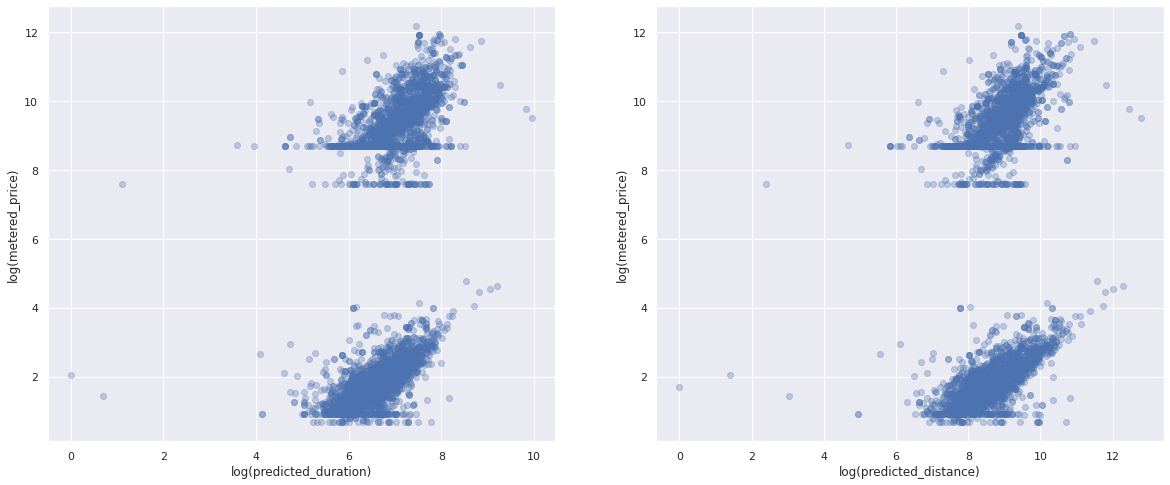

In [23]:
fig, ax = plt.subplots(1, 2, figsize=(20, 8))
ax[0].scatter(trips['predicted_duration'], trips['metered_price'], alpha=0.3)
ax[0].set_xlabel('log(predicted_duration)')
ax[0].set_ylabel('log(metered_price)')
ax[1].scatter(trips['predicted_distance'], trips['metered_price'], alpha=0.3)
ax[1].set_xlabel('log(predicted_distance)')
ax[1].set_ylabel('log(metered_price)')

I would recommend you [this](https://chart-studio.plotly.com/create/?fid=plotly2_demo:437#/) to build 3D interactive model.

/tmp/ipykernel_67848/806850964.py:8: MatplotlibDeprecationWarning: Auto-removal of grids by pcolor() and pcolormesh() is deprecated since 3.5 and will be removed two minor releases later; please call grid(False) first.
  plt.colorbar()


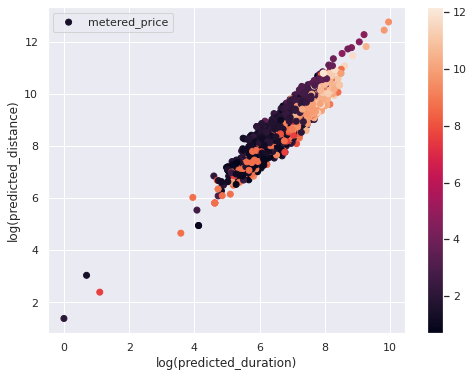

In [24]:
fig = plt.figure(figsize=(8, 6))
plt.scatter(trips['predicted_duration'], 
            trips['predicted_distance'], 
            c=trips['metered_price'], 
            label='metered_price')
plt.xlabel('log(predicted_duration)')
plt.ylabel('log(predicted_distance)')
plt.colorbar()
plt.legend()

# Clean up the trips

In [25]:
trips.describe()

,order_id_new,order_try_id_new,metered_price,upfront_price,distance,duration,gps_confidence,dest_change_number,predicted_distance,predicted_duration,ticket_id_new,device_token,driver_device_uid_new,eu_indicator,overpaid_ride_ticket,fraud_score
count,4943.000000,4943.000000,4923.000000,3409.000000,4943.000000,4943.000000,4943.000000,4943.000000,4923.000000,4923.000000,4943.000000,0.0,4943.000000,4943.000000,4943.000000,2184.000000
mean,2061.074449,2061.074044,5.186442,3.680963,9769.223144,1566.230629,0.800728,1.119361,-inf,-inf,2471.000000,NaN,1093.311349,0.560388,0.068177,-674.046703
std,1199.298429,1199.299081,3.857424,3.402727,10912.426401,1650.329858,0.399493,0.499611,NaN,NaN,1427.065521,NaN,626.408069,0.496390,0.252075,1119.189890
min,0.000000,0.000000,0.693147,0.693147,0.000000,0.000000,0.000000,1.000000,-inf,-inf,0.000000,NaN,0.000000,0.000000,0.000000,-14225.000000
25%,1020.500000,1020.500000,1.682688,1.435085,3785.500000,604.000000,1.000000,1.000000,8.326154,6.392754,1235.500000,NaN,561.500000,0.000000,0.000000,-826.500000
50%,2065.000000,2065.000000,2.591516,1.887070,7140.000000,1054.000000,1.000000,1.000000,8.841882,6.844815,2471.000000,NaN,1088.000000,1.000000,0.000000,-278.500000
75%,3090.500000,3090.500000,9.304893,8.294050,11953.000000,1929.500000,1.000000,1.000000,9.275566,7.263330,3706.500000,NaN,1643.000000,1.000000,0.000000,-64.750000
max,4165.000000,4165.000000,12.178103,13.296317,233190.000000,22402.000000,1.000000,12.000000,12.775746,9.951897,4942.000000,NaN,2158.000000,1.000000,1.000000,49.000000


In [26]:
class CleanTransformer(BaseEstimator, TransformerMixin):
    def __init__(self):
        pass
    
    def fit(self, X, y=None):
        return self
    
    def transform(self, X, y=None):
        cond = X['metered_price'].notna()  #  drop NaN from metered_price
        cond &= X['predicted_distance'] > 0  #  predicted_distance has to be positive
        cond &= X['predicted_duration'] > 0  #  predicted_duration has to be positive
        
        X.loc[:, 'change_reason_pricing'] = X['change_reason_pricing'].fillna('NONE')
        
        X = X.loc[cond]
        
        return X

In [27]:
trips = CleanTransformer().transform(trips)

We are going to use 'upfront_price' column to calculate out baseline.

# Add additional features

In [28]:
mask = trips['metered_price'].isin(np.log([2000, 6000, 2.5, 2]))

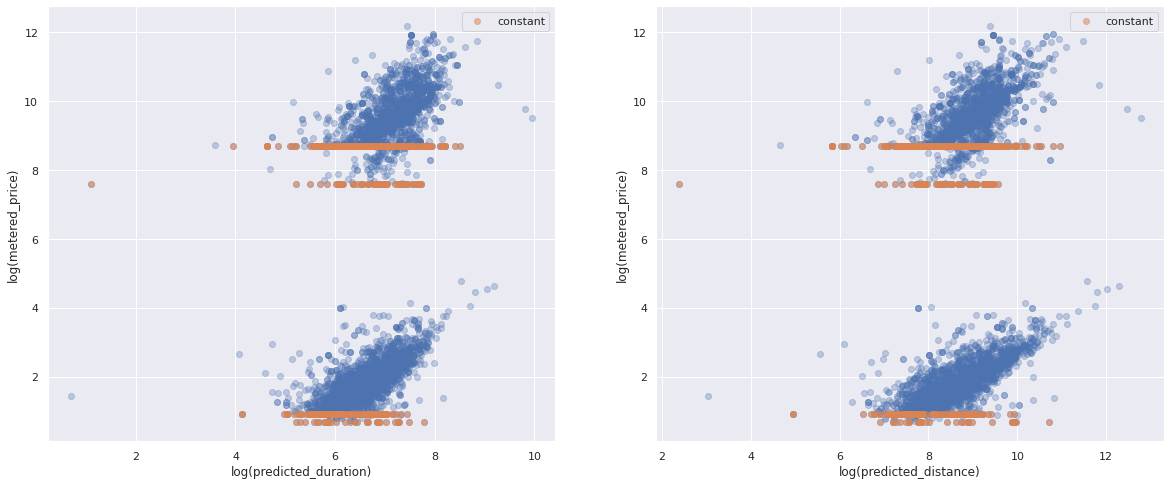

In [29]:
fig, ax = plt.subplots(1, 2, figsize=(20, 8))
ax[0].scatter(trips['predicted_duration'], trips['metered_price'], alpha=0.3)
ax[0].scatter(trips.loc[mask, 'predicted_duration'], 
              trips.loc[mask, 'metered_price'],
              label='constant', alpha=0.5)
ax[0].set_xlabel('log(predicted_duration)')
ax[0].set_ylabel('log(metered_price)')
ax[0].legend()
ax[1].scatter(trips['predicted_distance'], trips['metered_price'], alpha=0.3)
ax[1].scatter(trips.loc[mask, 'predicted_distance'], 
              trips.loc[mask, 'metered_price'],
              label='constant', alpha=0.5)
ax[1].set_xlabel('log(predicted_distance)')
ax[1].set_ylabel('log(metered_price)')
ax[1].legend()

As you can see above there are some price constants that don't change:
* log(2000) - some kind of an airport
* log(6000) - some kind of an airport

__Note. There is no any data leakage. All these constants can be derived from GPS coordinates.__

If I knew pickup and dropoff coordinates I would also add:
* weather conditions, 
* airport stations,
* good/bad neighbourhoods.

Text(0, 0.5, 'log(metered_price)')

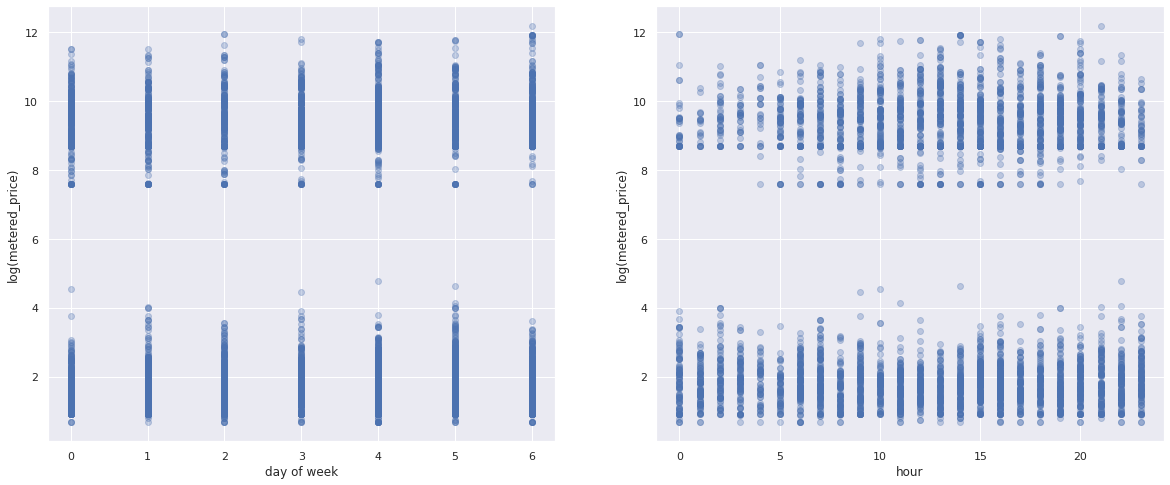

In [59]:
fig, ax = plt.subplots(1, 2, figsize=(20, 8))
ax[0].scatter(trips['calc_created'].dt.dayofweek, trips['metered_price'], alpha=0.3)
ax[0].set_xlabel('day of week')
ax[0].set_ylabel('log(metered_price)')
ax[1].scatter(trips['calc_created'].dt.hour, trips['metered_price'], alpha=0.3)
ax[1].set_xlabel('hour')
ax[1].set_ylabel('log(metered_price)')

In [125]:
class FeatureTransformer(BaseEstimator, TransformerMixin):
    def __init__(self):
        pass
    
    def fit(self, X, y=None):
        return self
    
    @staticmethod
    def get_part_day(x):
        if (x > 4) and (x <= 8):
            return 'Early Morning'
        elif (x > 8) and (x <= 12 ):
            return 'Morning'
        elif (x > 12) and (x <= 16):
            return'Noon'
        elif (x > 16) and (x <= 20) :
            return 'Eve'
        elif (x > 20) and (x <= 24):
            return'Night'
        elif (x <= 4):
            return'Late Night'
    
    def transform(self, X, y=None):
        X.loc[:, 'day_of_week'] = X['calc_created'].dt.dayofweek
        X.loc[:, 'is_weekend'] = X['day_of_week'] > 4
#         X.loc[:, 'month'] = X['calc_created'].dt.month
        X.loc[:, 'hour_of_day'] = X['calc_created'].dt.hour
        X.loc[:, 'part_of_day'] = X['hour_of_day'].apply(self.get_part_day)
        
        X.loc[:, 'speed'] = X['predicted_distance'] / X['predicted_duration']
#         grouped = ['order_id_new', 'calc_created']
#         cnt_ticket_id_new = X.groupby(grouped)['ticket_id_new'].count().reset_index()
#         cnt_ticket_id_new = cnt_ticket_id_new.rename(columns={'ticket_id_new': 'cnt_ticket_id_new'})
#         X = pd.merge(X, cnt_ticket_id_new, how='left', on=grouped)
        
        X.loc[:, 'isairport_2000'] = X['metered_price'] == np.log(2000)
        X.loc[:, 'isairport_6000'] = X['metered_price'] == np.log(6000)
#         X.loc[:, 'rush_idle_hour'] = np.log(2.5)
#         X.loc[:, 'init_charge'] = np.log(2)
        
        return X

In [31]:
trips = FeatureTransformer().transform(trips)

In [32]:
UPFRONT_PRICE = trips.loc[:, 'upfront_price']

## One-hot-encoding of categorical features

In [126]:
CATEGORICAL_COLS = [
    'day_of_week', 'part_of_day',
    'dest_change_number', 'prediction_price_type', 
    'change_reason_pricing', 'entered_by',
]
        
DROP_COLS = [
    'order_id_new', 'calc_created', 'upfront_price', 
    'order_try_id_new', 'distance', 'duration', 'ticket_id_new',
    'b_state', 'device_token', 'rider_app_version', 'order_state',
    'order_try_state', 'driver_app_version', 'driver_device_uid_new',
    'device_name', 'fraud_score'
]

In [127]:
class ColumnTransformer(BaseEstimator, TransformerMixin):
    def __init__(self, drop_cols, categorical_cols):
        self.categorical_cols = categorical_cols
        self.drop_cols = drop_cols
    
    def fit(self, X, y=None):
        return self
    
    def transform(self, X, y=None):
        X = pd.get_dummies(X, columns=self.categorical_cols)
        X.drop(columns=self.drop_cols, inplace=True)
        
        return X

In [35]:
trips = ColumnTransformer(DROP_COLS, CATEGORICAL_COLS).transform(trips)

# Support functions

To compare quality of our models we are going to use RMSE metric.

In [36]:
def rmse_decorator(func):
    @functools.wraps(func)
    def wrapper_rmse(*args, **kwargs):
        if len(args) == 3:
            return make_scorer(func)(*args, **kwargs) 
        else:
            return func(*args, **kwargs)
    
    return wrapper_rmse


@rmse_decorator
def rmse(y_true, y_pred):
    return mean_squared_error(y_true, y_pred, squared=False)

In [37]:
def print_results(estimator, X_test, y_test):
    print('R^2 = {:.5f}'.format(estimator.score(X_test, y_test)))
    print('RMSE = {:.5f}'.format(rmse(estimator, X_test, y_test)))
    mask = UPFRONT_PRICE[y_test.index].notna()
    baseline = rmse(y_test.loc[mask], UPFRONT_PRICE[y_test.index].loc[mask])
    print('Baseline RMSE = {:.5f}'.format(baseline))

In [38]:
def plot_results(X, y, y_pred):
    fig, ax = plt.subplots(1, 2, figsize=(20, 8))
    ax[0].scatter(X['test']['predicted_duration'], y['test'], label='test')
    ax[0].scatter(X['test']['predicted_duration'], y_pred, label='pred')
    ax[0].set_xlabel('log(predicted_duration)')
    ax[0].set_ylabel('log(metered_price)')
    ax[0].legend()
    ax[1].scatter(X['test']['predicted_distance'], y['test'], label='test')
    ax[1].scatter(X['test']['predicted_distance'], y_pred, label='pred')
    ax[1].set_xlabel('log(predicted_distance)')
    ax[1].set_ylabel('log(metered_price)')
    ax[1].legend()

In [39]:
class TrainTestSplitTransformer(BaseEstimator, TransformerMixin):
    def __init__(self, random_state=None):
        self.random_state = random_state
    
    @staticmethod
    def train_test_split(features, labels, train_size=.8, test_size=.2, **params):
        X, y = {}, {}

        X['train'], X['test'], y['train'], y['test'] = _train_test_split(
            features, 
            labels, 
            test_size=test_size, 
            train_size=train_size, 
            **params
        )

        return X, y
    
    def fit(self, X, y=None):
        return self
    
    def transform(self, X, y=None):
        labels = X.loc[:, 'metered_price']
        features = X.drop(columns=['metered_price'])

        return self.train_test_split(features, labels, random_state=self.random_state)

In [40]:
class TrainValidTestSplitTransformer(BaseEstimator, TransformerMixin):
    def __init__(self, random_state=None):
        self.random_state = random_state
    
    @staticmethod
    def train_valid_test_split(features, labels, train_size=.6, test_size=.2, valid_size=.2, **params):
        X, y = {}, {}

        X_train_valid, X['test'], y_train_valid, y['test'] = _train_test_split(
            features, 
            labels, 
            test_size=test_size, 
            train_size=train_size + valid_size,
            **params
        )
        X['train'], X['valid'], y['train'], y['valid'] = _train_test_split(
            X_train_valid, 
            y_train_valid, 
            test_size=valid_size, 
            train_size=train_size + test_size, 
            **params
        )

        return X, y
    
    def fit(self, X, y=None):
        return self
    
    def transform(self, X, y=None):
        labels = X.loc[:, 'metered_price']
        features = X.drop(columns=['metered_price'])

        return self.train_valid_test_split(features, labels, random_state=self.random_state)

In [128]:
steps = [
    ('log_transformer', LogTransformer(LOGCOLS)),
    ('clean_transformer', CleanTransformer()),
    ('feature_transformer', FeatureTransformer()),
    ('column_transformer', ColumnTransformer(DROP_COLS, CATEGORICAL_COLS))
]

preprocessing = Pipeline(steps)

steps = [
    ('preprocessing', preprocessing),
    ('splitting', TrainTestSplitTransformer(random_state=42)),
]

train_test_splitting = Pipeline(steps)

steps = [
    ('preprocessing', preprocessing),
    ('splitting', TrainValidTestSplitTransformer(random_state=42)),
]

train_valid_test_splitting = Pipeline(steps)

In [88]:
# preprocessing.transform(download_dataset(DOWNLOAD_URL))

# Linear model

In [89]:
trips = download_dataset(DOWNLOAD_URL)
X, y = train_test_splitting.transform(trips)

In [90]:
steps = [
    ('poly', PolynomialFeatures(degree=2, include_bias=False, interaction_only=False)),
    ('scaler', StandardScaler()),
    ('ridge', RidgeCV(alphas=[7, 10, 11, 15, 18, 20]))
]
linear_pipe = Pipeline(steps)
linear_pipe.fit(X['train'], y['train'])
print('best_alpha = {}'.format(linear_pipe['ridge'].alpha_))
y_pred = linear_pipe.predict(X['test'])
print_results(linear_pipe, X['test'], y['test'])

best_alpha = 20
R^2 = 0.98769
RMSE = 0.42584
Baseline RMSE = 0.41872


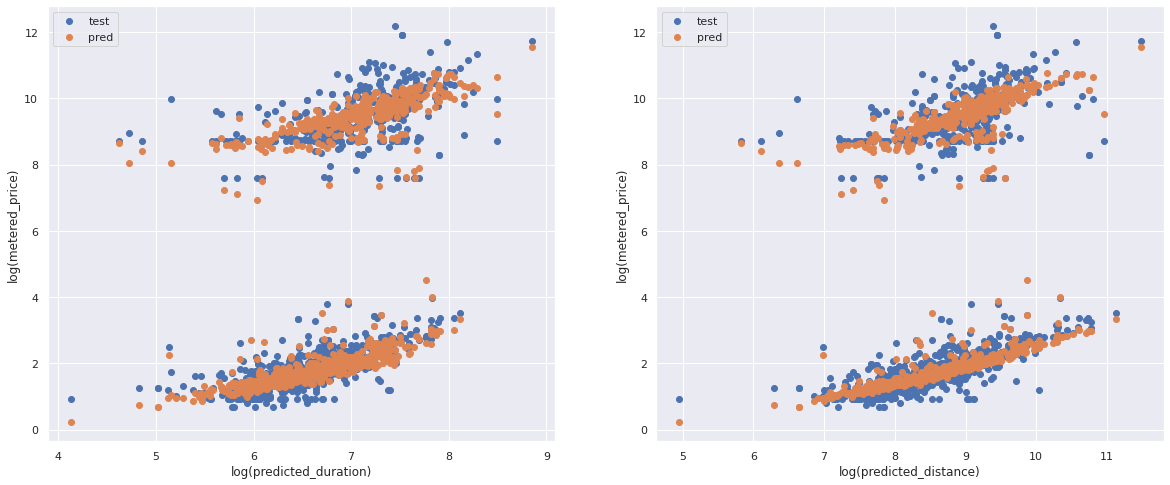

In [91]:
plot_results(X, y, y_pred)

## LGBM

In [129]:
trips = download_dataset(DOWNLOAD_URL)
X, y = train_valid_test_splitting.transform(trips)

In [130]:
steps = [
    ('poly', PolynomialFeatures(degree=2, include_bias=False, interaction_only=False)),
    ('scaler', StandardScaler()),
#     ('lgb', lgb.LGBMRegressor(random_state=42))
]
lgb_pipe = Pipeline(steps)

param_grid = {
    'max_depth': [5, 10, 20, 30],
    'n_estimators': [50, 70, 80, 100],
    'early_stopping_rounds': [10]
}


grid_search = GridSearchCV(estimator=lgb.LGBMRegressor(random_state=42), 
                           param_grid=param_grid, 
                           cv=5, n_jobs=-1, verbose=2)
grid_search.fit(lgb_pipe.fit_transform(X['train']), y['train'], 
                eval_set=[(lgb_pipe.transform(X['valid']), y['valid'])], 
                eval_metric='rmse')

Fitting 5 folds for each of 16 candidates, totalling 80 fits
[LightGBM] [Warning] early_stopping_round is set=10, early_stopping_rounds=10 will be ignored. Current value: early_stopping_round=10
[1]	valid_0's rmse: 3.49369	valid_0's l2: 12.2059
[2]	valid_0's rmse: 3.15314	valid_0's l2: 9.94232
[3]	valid_0's rmse: 2.84705	valid_0's l2: 8.10567
[4]	valid_0's rmse: 2.5733	valid_0's l2: 6.62187
[5]	valid_0's rmse: 2.3274	valid_0's l2: 5.41678
[6]	valid_0's rmse: 2.10631	valid_0's l2: 4.43655
[7]	valid_0's rmse: 1.90916	valid_0's l2: 3.64488
[8]	valid_0's rmse: 1.73235	valid_0's l2: 3.00103
[9]	valid_0's rmse: 1.5732	valid_0's l2: 2.47496
[10]	valid_0's rmse: 1.43143	valid_0's l2: 2.04901
[11]	valid_0's rmse: 1.30531	valid_0's l2: 1.70382
[12]	valid_0's rmse: 1.19311	valid_0's l2: 1.4235
[13]	valid_0's rmse: 1.09333	valid_0's l2: 1.19536
[14]	valid_0's rmse: 1.00577	valid_0's l2: 1.01157
[15]	valid_0's rmse: 0.928008	valid_0's l2: 0.861198
[16]	valid_0's rmse: 0.859566	valid_0's l2: 0.73885

[50]	valid_0's rmse: 0.449477	valid_0's l2: 0.202029
[CV] END early_stopping_rounds=10, max_depth=5, n_estimators=50; total time=   0.7s
[LightGBM] [Warning] early_stopping_round is set=10, early_stopping_rounds=10 will be ignored. Current value: early_stopping_round=10
[1]	valid_0's rmse: 3.49309	valid_0's l2: 12.2017
[2]	valid_0's rmse: 3.15188	valid_0's l2: 9.93433
[3]	valid_0's rmse: 2.84584	valid_0's l2: 8.09879
[4]	valid_0's rmse: 2.57076	valid_0's l2: 6.60879
[5]	valid_0's rmse: 2.32416	valid_0's l2: 5.4017
[6]	valid_0's rmse: 2.10294	valid_0's l2: 4.42234
[7]	valid_0's rmse: 1.90577	valid_0's l2: 3.63196
[8]	valid_0's rmse: 1.72938	valid_0's l2: 2.99075
[9]	valid_0's rmse: 1.57139	valid_0's l2: 2.46925
[10]	valid_0's rmse: 1.43059	valid_0's l2: 2.0466
[11]	valid_0's rmse: 1.30449	valid_0's l2: 1.7017
[12]	valid_0's rmse: 1.19194	valid_0's l2: 1.42072
[13]	valid_0's rmse: 1.09188	valid_0's l2: 1.19221
[14]	valid_0's rmse: 1.00368	valid_0's l2: 1.00737
[15]	valid_0's rmse: 0.9261

[56]	valid_0's rmse: 0.441818	valid_0's l2: 0.195203
[57]	valid_0's rmse: 0.441673	valid_0's l2: 0.195075
[58]	valid_0's rmse: 0.441736	valid_0's l2: 0.19513
[59]	valid_0's rmse: 0.441917	valid_0's l2: 0.19529
[60]	valid_0's rmse: 0.441778	valid_0's l2: 0.195167
[61]	valid_0's rmse: 0.441912	valid_0's l2: 0.195286
[62]	valid_0's rmse: 0.441303	valid_0's l2: 0.194748
[63]	valid_0's rmse: 0.441277	valid_0's l2: 0.194726
[64]	valid_0's rmse: 0.441334	valid_0's l2: 0.194776
[65]	valid_0's rmse: 0.441086	valid_0's l2: 0.194557
[66]	valid_0's rmse: 0.441184	valid_0's l2: 0.194643
[67]	valid_0's rmse: 0.440522	valid_0's l2: 0.194059
[68]	valid_0's rmse: 0.440539	valid_0's l2: 0.194074
[69]	valid_0's rmse: 0.440066	valid_0's l2: 0.193658
[70]	valid_0's rmse: 0.440124	valid_0's l2: 0.193709
[CV] END early_stopping_rounds=10, max_depth=5, n_estimators=70; total time=   0.8s
[LightGBM] [Warning] early_stopping_round is set=10, early_stopping_rounds=10 will be ignored. Current value: early_stoppin

[1]	valid_0's rmse: 3.49309	valid_0's l2: 12.2017
[2]	valid_0's rmse: 3.15188	valid_0's l2: 9.93433
[3]	valid_0's rmse: 2.84584	valid_0's l2: 8.09879
[4]	valid_0's rmse: 2.57076	valid_0's l2: 6.60879
[5]	valid_0's rmse: 2.32416	valid_0's l2: 5.4017
[6]	valid_0's rmse: 2.10294	valid_0's l2: 4.42234
[7]	valid_0's rmse: 1.90577	valid_0's l2: 3.63196
[8]	valid_0's rmse: 1.72938	valid_0's l2: 2.99075
[9]	valid_0's rmse: 1.57139	valid_0's l2: 2.46925
[10]	valid_0's rmse: 1.43059	valid_0's l2: 2.0466
[11]	valid_0's rmse: 1.30449	valid_0's l2: 1.7017
[12]	valid_0's rmse: 1.19194	valid_0's l2: 1.42072
[13]	valid_0's rmse: 1.09188	valid_0's l2: 1.19221
[14]	valid_0's rmse: 1.00368	valid_0's l2: 1.00737
[15]	valid_0's rmse: 0.926103	valid_0's l2: 0.857666
[16]	valid_0's rmse: 0.857529	valid_0's l2: 0.735356
[17]	valid_0's rmse: 0.798112	valid_0's l2: 0.636982
[18]	valid_0's rmse: 0.746272	valid_0's l2: 0.556921
[19]	valid_0's rmse: 0.701315	valid_0's l2: 0.491842
[20]	valid_0's rmse: 0.662439	val

[53]	valid_0's rmse: 0.442459	valid_0's l2: 0.19577
[54]	valid_0's rmse: 0.442096	valid_0's l2: 0.195449
[55]	valid_0's rmse: 0.441787	valid_0's l2: 0.195176
[56]	valid_0's rmse: 0.441818	valid_0's l2: 0.195203
[57]	valid_0's rmse: 0.441673	valid_0's l2: 0.195075
[58]	valid_0's rmse: 0.441736	valid_0's l2: 0.19513
[59]	valid_0's rmse: 0.441917	valid_0's l2: 0.19529
[60]	valid_0's rmse: 0.441778	valid_0's l2: 0.195167
[61]	valid_0's rmse: 0.441912	valid_0's l2: 0.195286
[62]	valid_0's rmse: 0.441303	valid_0's l2: 0.194748
[63]	valid_0's rmse: 0.441277	valid_0's l2: 0.194726
[64]	valid_0's rmse: 0.441334	valid_0's l2: 0.194776
[65]	valid_0's rmse: 0.441086	valid_0's l2: 0.194557
[66]	valid_0's rmse: 0.441184	valid_0's l2: 0.194643
[67]	valid_0's rmse: 0.440522	valid_0's l2: 0.194059
[68]	valid_0's rmse: 0.440539	valid_0's l2: 0.194074
[69]	valid_0's rmse: 0.440066	valid_0's l2: 0.193658
[70]	valid_0's rmse: 0.440124	valid_0's l2: 0.193709
[71]	valid_0's rmse: 0.44037	valid_0's l2: 0.1939

[52]	valid_0's rmse: 0.448464	valid_0's l2: 0.20112
[53]	valid_0's rmse: 0.448594	valid_0's l2: 0.201236
[54]	valid_0's rmse: 0.448356	valid_0's l2: 0.201023
[55]	valid_0's rmse: 0.448725	valid_0's l2: 0.201354
[56]	valid_0's rmse: 0.448723	valid_0's l2: 0.201352
[57]	valid_0's rmse: 0.448718	valid_0's l2: 0.201348
[58]	valid_0's rmse: 0.448777	valid_0's l2: 0.2014
[59]	valid_0's rmse: 0.448954	valid_0's l2: 0.20156
[60]	valid_0's rmse: 0.448875	valid_0's l2: 0.201488
[61]	valid_0's rmse: 0.448837	valid_0's l2: 0.201454
[62]	valid_0's rmse: 0.448745	valid_0's l2: 0.201372
[63]	valid_0's rmse: 0.448839	valid_0's l2: 0.201457
[64]	valid_0's rmse: 0.448678	valid_0's l2: 0.201312
[CV] END early_stopping_rounds=10, max_depth=5, n_estimators=80; total time=   0.6s
[LightGBM] [Warning] early_stopping_round is set=10, early_stopping_rounds=10 will be ignored. Current value: early_stopping_round=10
[1]	valid_0's rmse: 3.49309	valid_0's l2: 12.2017
[2]	valid_0's rmse: 3.15188	valid_0's l2: 9.934

[1]	valid_0's rmse: 3.49369	valid_0's l2: 12.2059
[2]	valid_0's rmse: 3.15314	valid_0's l2: 9.94232
[3]	valid_0's rmse: 2.84705	valid_0's l2: 8.10567
[4]	valid_0's rmse: 2.5733	valid_0's l2: 6.62187
[5]	valid_0's rmse: 2.3274	valid_0's l2: 5.41678
[6]	valid_0's rmse: 2.10631	valid_0's l2: 4.43655
[7]	valid_0's rmse: 1.90916	valid_0's l2: 3.64488
[8]	valid_0's rmse: 1.73235	valid_0's l2: 3.00103
[9]	valid_0's rmse: 1.5732	valid_0's l2: 2.47496
[10]	valid_0's rmse: 1.43143	valid_0's l2: 2.04901
[11]	valid_0's rmse: 1.30531	valid_0's l2: 1.70382
[12]	valid_0's rmse: 1.19311	valid_0's l2: 1.4235
[13]	valid_0's rmse: 1.09333	valid_0's l2: 1.19536
[14]	valid_0's rmse: 1.00577	valid_0's l2: 1.01157
[15]	valid_0's rmse: 0.928008	valid_0's l2: 0.861198
[16]	valid_0's rmse: 0.859566	valid_0's l2: 0.738854
[17]	valid_0's rmse: 0.799994	valid_0's l2: 0.63999
[18]	valid_0's rmse: 0.747962	valid_0's l2: 0.559448
[19]	valid_0's rmse: 0.702607	valid_0's l2: 0.493656
[20]	valid_0's rmse: 0.66391	valid_

[1]	valid_0's rmse: 3.49299	valid_0's l2: 12.201
[2]	valid_0's rmse: 3.15146	valid_0's l2: 9.93168
[3]	valid_0's rmse: 2.84424	valid_0's l2: 8.08973
[4]	valid_0's rmse: 2.56901	valid_0's l2: 6.59983
[5]	valid_0's rmse: 2.32186	valid_0's l2: 5.39103
[6]	valid_0's rmse: 2.10036	valid_0's l2: 4.41151
[7]	valid_0's rmse: 1.90231	valid_0's l2: 3.61878
[8]	valid_0's rmse: 1.72599	valid_0's l2: 2.97905
[9]	valid_0's rmse: 1.56787	valid_0's l2: 2.45821
[10]	valid_0's rmse: 1.42639	valid_0's l2: 2.03458
[11]	valid_0's rmse: 1.29985	valid_0's l2: 1.68961
[12]	valid_0's rmse: 1.18745	valid_0's l2: 1.41003
[13]	valid_0's rmse: 1.08776	valid_0's l2: 1.18322
[14]	valid_0's rmse: 0.999331	valid_0's l2: 0.998663
[15]	valid_0's rmse: 0.922009	valid_0's l2: 0.8501
[16]	valid_0's rmse: 0.853993	valid_0's l2: 0.729304
[17]	valid_0's rmse: 0.795179	valid_0's l2: 0.632309
[18]	valid_0's rmse: 0.743294	valid_0's l2: 0.552486
[19]	valid_0's rmse: 0.698669	valid_0's l2: 0.488138
[20]	valid_0's rmse: 0.659684	v

[50]	valid_0's rmse: 0.447207	valid_0's l2: 0.199994
[51]	valid_0's rmse: 0.446705	valid_0's l2: 0.199545
[52]	valid_0's rmse: 0.446579	valid_0's l2: 0.199433
[53]	valid_0's rmse: 0.446215	valid_0's l2: 0.199108
[54]	valid_0's rmse: 0.446254	valid_0's l2: 0.199142
[55]	valid_0's rmse: 0.446708	valid_0's l2: 0.199548
[56]	valid_0's rmse: 0.446606	valid_0's l2: 0.199457
[57]	valid_0's rmse: 0.446837	valid_0's l2: 0.199664
[58]	valid_0's rmse: 0.446848	valid_0's l2: 0.199673
[59]	valid_0's rmse: 0.447125	valid_0's l2: 0.19992
[60]	valid_0's rmse: 0.447109	valid_0's l2: 0.199906
[61]	valid_0's rmse: 0.446736	valid_0's l2: 0.199573
[62]	valid_0's rmse: 0.447014	valid_0's l2: 0.199821
[63]	valid_0's rmse: 0.446774	valid_0's l2: 0.199607
[CV] END early_stopping_rounds=10, max_depth=5, n_estimators=100; total time=   0.6s
[LightGBM] [Warning] early_stopping_round is set=10, early_stopping_rounds=10 will be ignored. Current value: early_stopping_round=10
[1]	valid_0's rmse: 3.49254	valid_0's l2

[LightGBM] [Warning] early_stopping_round is set=10, early_stopping_rounds=10 will be ignored. Current value: early_stopping_round=10
[1]	valid_0's rmse: 3.49264	valid_0's l2: 12.1986
[2]	valid_0's rmse: 3.15129	valid_0's l2: 9.93062
[3]	valid_0's rmse: 2.84443	valid_0's l2: 8.09078
[4]	valid_0's rmse: 2.56872	valid_0's l2: 6.5983
[5]	valid_0's rmse: 2.32263	valid_0's l2: 5.3946
[6]	valid_0's rmse: 2.1018	valid_0's l2: 4.41758
[7]	valid_0's rmse: 1.90392	valid_0's l2: 3.62491
[8]	valid_0's rmse: 1.72593	valid_0's l2: 2.97884
[9]	valid_0's rmse: 1.56673	valid_0's l2: 2.45464
[10]	valid_0's rmse: 1.42494	valid_0's l2: 2.03047
[11]	valid_0's rmse: 1.29889	valid_0's l2: 1.68712
[12]	valid_0's rmse: 1.18501	valid_0's l2: 1.40425
[13]	valid_0's rmse: 1.08448	valid_0's l2: 1.1761
[14]	valid_0's rmse: 0.995357	valid_0's l2: 0.990736
[15]	valid_0's rmse: 0.916665	valid_0's l2: 0.840275
[16]	valid_0's rmse: 0.847775	valid_0's l2: 0.718722
[17]	valid_0's rmse: 0.787201	valid_0's l2: 0.619686
[18]

[55]	valid_0's rmse: 0.429841	valid_0's l2: 0.184764
[56]	valid_0's rmse: 0.429351	valid_0's l2: 0.184343
[57]	valid_0's rmse: 0.429551	valid_0's l2: 0.184514
[58]	valid_0's rmse: 0.429605	valid_0's l2: 0.184561
[59]	valid_0's rmse: 0.429654	valid_0's l2: 0.184602
[60]	valid_0's rmse: 0.429777	valid_0's l2: 0.184709
[61]	valid_0's rmse: 0.429696	valid_0's l2: 0.184639
[62]	valid_0's rmse: 0.429576	valid_0's l2: 0.184536
[63]	valid_0's rmse: 0.429591	valid_0's l2: 0.184549
[64]	valid_0's rmse: 0.429247	valid_0's l2: 0.184253
[65]	valid_0's rmse: 0.429342	valid_0's l2: 0.184335
[66]	valid_0's rmse: 0.429323	valid_0's l2: 0.184318
[67]	valid_0's rmse: 0.429346	valid_0's l2: 0.184338
[68]	valid_0's rmse: 0.429537	valid_0's l2: 0.184502
[69]	valid_0's rmse: 0.429648	valid_0's l2: 0.184597
[70]	valid_0's rmse: 0.429605	valid_0's l2: 0.18456
[CV] END early_stopping_rounds=10, max_depth=10, n_estimators=70; total time=   0.8s
[LightGBM] [Warning] early_stopping_round is set=10, early_stopping_

[1]	valid_0's rmse: 3.49264	valid_0's l2: 12.1986
[2]	valid_0's rmse: 3.15129	valid_0's l2: 9.93062
[3]	valid_0's rmse: 2.84443	valid_0's l2: 8.09078
[4]	valid_0's rmse: 2.56872	valid_0's l2: 6.5983
[5]	valid_0's rmse: 2.32263	valid_0's l2: 5.3946
[6]	valid_0's rmse: 2.1018	valid_0's l2: 4.41758
[7]	valid_0's rmse: 1.90392	valid_0's l2: 3.62491
[8]	valid_0's rmse: 1.72593	valid_0's l2: 2.97884
[9]	valid_0's rmse: 1.56673	valid_0's l2: 2.45464
[10]	valid_0's rmse: 1.42494	valid_0's l2: 2.03047
[11]	valid_0's rmse: 1.29889	valid_0's l2: 1.68712
[12]	valid_0's rmse: 1.18501	valid_0's l2: 1.40425
[13]	valid_0's rmse: 1.08448	valid_0's l2: 1.1761
[14]	valid_0's rmse: 0.995357	valid_0's l2: 0.990736
[15]	valid_0's rmse: 0.916665	valid_0's l2: 0.840275
[16]	valid_0's rmse: 0.847775	valid_0's l2: 0.718722
[17]	valid_0's rmse: 0.787201	valid_0's l2: 0.619686
[18]	valid_0's rmse: 0.734901	valid_0's l2: 0.540079
[19]	valid_0's rmse: 0.68896	valid_0's l2: 0.474666
[20]	valid_0's rmse: 0.649439	val

[29]	valid_0's rmse: 0.477104	valid_0's l2: 0.227628
[30]	valid_0's rmse: 0.468589	valid_0's l2: 0.219576
[31]	valid_0's rmse: 0.461886	valid_0's l2: 0.213339
[32]	valid_0's rmse: 0.456439	valid_0's l2: 0.208336
[33]	valid_0's rmse: 0.452375	valid_0's l2: 0.204644
[34]	valid_0's rmse: 0.448707	valid_0's l2: 0.201338
[35]	valid_0's rmse: 0.445879	valid_0's l2: 0.198808
[36]	valid_0's rmse: 0.443511	valid_0's l2: 0.196702
[37]	valid_0's rmse: 0.441785	valid_0's l2: 0.195174
[38]	valid_0's rmse: 0.440255	valid_0's l2: 0.193824
[39]	valid_0's rmse: 0.439198	valid_0's l2: 0.192895
[40]	valid_0's rmse: 0.438474	valid_0's l2: 0.192259
[41]	valid_0's rmse: 0.437405	valid_0's l2: 0.191323
[42]	valid_0's rmse: 0.436571	valid_0's l2: 0.190594
[43]	valid_0's rmse: 0.435756	valid_0's l2: 0.189883
[44]	valid_0's rmse: 0.43535	valid_0's l2: 0.18953
[45]	valid_0's rmse: 0.434583	valid_0's l2: 0.188863
[46]	valid_0's rmse: 0.434029	valid_0's l2: 0.188381
[47]	valid_0's rmse: 0.432795	valid_0's l2: 0.18

[28]	valid_0's rmse: 0.486579	valid_0's l2: 0.236759
[29]	valid_0's rmse: 0.478599	valid_0's l2: 0.229057
[30]	valid_0's rmse: 0.471525	valid_0's l2: 0.222335
[31]	valid_0's rmse: 0.465727	valid_0's l2: 0.216901
[32]	valid_0's rmse: 0.461002	valid_0's l2: 0.212523
[33]	valid_0's rmse: 0.456357	valid_0's l2: 0.208262
[34]	valid_0's rmse: 0.453608	valid_0's l2: 0.20576
[35]	valid_0's rmse: 0.450848	valid_0's l2: 0.203264
[36]	valid_0's rmse: 0.449104	valid_0's l2: 0.201695
[37]	valid_0's rmse: 0.446953	valid_0's l2: 0.199767
[38]	valid_0's rmse: 0.445237	valid_0's l2: 0.198236
[39]	valid_0's rmse: 0.443677	valid_0's l2: 0.196849
[40]	valid_0's rmse: 0.442648	valid_0's l2: 0.195937
[41]	valid_0's rmse: 0.441756	valid_0's l2: 0.195149
[42]	valid_0's rmse: 0.441697	valid_0's l2: 0.195096
[43]	valid_0's rmse: 0.441665	valid_0's l2: 0.195068
[44]	valid_0's rmse: 0.441486	valid_0's l2: 0.19491
[45]	valid_0's rmse: 0.44107	valid_0's l2: 0.194543
[46]	valid_0's rmse: 0.44128	valid_0's l2: 0.1947

[54]	valid_0's rmse: 0.441827	valid_0's l2: 0.195211
[55]	valid_0's rmse: 0.441887	valid_0's l2: 0.195264
[56]	valid_0's rmse: 0.44147	valid_0's l2: 0.194896
[57]	valid_0's rmse: 0.441508	valid_0's l2: 0.194929
[58]	valid_0's rmse: 0.441563	valid_0's l2: 0.194978
[59]	valid_0's rmse: 0.441382	valid_0's l2: 0.194818
[60]	valid_0's rmse: 0.441428	valid_0's l2: 0.194859
[61]	valid_0's rmse: 0.44151	valid_0's l2: 0.194931
[62]	valid_0's rmse: 0.441048	valid_0's l2: 0.194523
[63]	valid_0's rmse: 0.440833	valid_0's l2: 0.194334
[64]	valid_0's rmse: 0.440741	valid_0's l2: 0.194253
[65]	valid_0's rmse: 0.441142	valid_0's l2: 0.194606
[66]	valid_0's rmse: 0.441273	valid_0's l2: 0.194722
[67]	valid_0's rmse: 0.441106	valid_0's l2: 0.194575
[68]	valid_0's rmse: 0.441223	valid_0's l2: 0.194678
[69]	valid_0's rmse: 0.441049	valid_0's l2: 0.194524
[70]	valid_0's rmse: 0.441117	valid_0's l2: 0.194584
[71]	valid_0's rmse: 0.441155	valid_0's l2: 0.194617
[72]	valid_0's rmse: 0.440906	valid_0's l2: 0.19

[54]	valid_0's rmse: 0.441636	valid_0's l2: 0.195042
[55]	valid_0's rmse: 0.441697	valid_0's l2: 0.195097
[56]	valid_0's rmse: 0.441749	valid_0's l2: 0.195142
[57]	valid_0's rmse: 0.441532	valid_0's l2: 0.194951
[58]	valid_0's rmse: 0.441671	valid_0's l2: 0.195074
[59]	valid_0's rmse: 0.44145	valid_0's l2: 0.194878
[60]	valid_0's rmse: 0.441459	valid_0's l2: 0.194886
[61]	valid_0's rmse: 0.441688	valid_0's l2: 0.195088
[62]	valid_0's rmse: 0.441695	valid_0's l2: 0.195095
[63]	valid_0's rmse: 0.44154	valid_0's l2: 0.194958
[64]	valid_0's rmse: 0.441275	valid_0's l2: 0.194724
[65]	valid_0's rmse: 0.441124	valid_0's l2: 0.194591
[66]	valid_0's rmse: 0.441494	valid_0's l2: 0.194917
[67]	valid_0's rmse: 0.441523	valid_0's l2: 0.194942
[68]	valid_0's rmse: 0.44168	valid_0's l2: 0.195081
[69]	valid_0's rmse: 0.441517	valid_0's l2: 0.194937
[70]	valid_0's rmse: 0.441196	valid_0's l2: 0.194654
[71]	valid_0's rmse: 0.441341	valid_0's l2: 0.194782
[72]	valid_0's rmse: 0.441525	valid_0's l2: 0.194

[57]	valid_0's rmse: 0.439705	valid_0's l2: 0.193341
[58]	valid_0's rmse: 0.43928	valid_0's l2: 0.192967
[59]	valid_0's rmse: 0.439186	valid_0's l2: 0.192885
[60]	valid_0's rmse: 0.439013	valid_0's l2: 0.192733
[61]	valid_0's rmse: 0.439093	valid_0's l2: 0.192803
[62]	valid_0's rmse: 0.439127	valid_0's l2: 0.192833
[63]	valid_0's rmse: 0.439412	valid_0's l2: 0.193083
[64]	valid_0's rmse: 0.439119	valid_0's l2: 0.192826
[65]	valid_0's rmse: 0.439458	valid_0's l2: 0.193123
[66]	valid_0's rmse: 0.439531	valid_0's l2: 0.193188
[67]	valid_0's rmse: 0.439469	valid_0's l2: 0.193133
[68]	valid_0's rmse: 0.439764	valid_0's l2: 0.193393
[69]	valid_0's rmse: 0.4397	valid_0's l2: 0.193336
[70]	valid_0's rmse: 0.440111	valid_0's l2: 0.193698
[CV] END early_stopping_rounds=10, max_depth=10, n_estimators=100; total time=   0.8s
[LightGBM] [Warning] early_stopping_round is set=10, early_stopping_rounds=10 will be ignored. Current value: early_stopping_round=10
[1]	valid_0's rmse: 3.48933	valid_0's l2:

[CV] END early_stopping_rounds=10, max_depth=20, n_estimators=50; total time=   0.7s
[LightGBM] [Warning] early_stopping_round is set=10, early_stopping_rounds=10 will be ignored. Current value: early_stopping_round=10
[1]	valid_0's rmse: 3.48994	valid_0's l2: 12.1797
[2]	valid_0's rmse: 3.14891	valid_0's l2: 9.91561
[3]	valid_0's rmse: 2.8418	valid_0's l2: 8.07584
[4]	valid_0's rmse: 2.56644	valid_0's l2: 6.58661
[5]	valid_0's rmse: 2.31931	valid_0's l2: 5.37918
[6]	valid_0's rmse: 2.09837	valid_0's l2: 4.40317
[7]	valid_0's rmse: 1.9	valid_0's l2: 3.60999
[8]	valid_0's rmse: 1.7222	valid_0's l2: 2.96597
[9]	valid_0's rmse: 1.56292	valid_0's l2: 2.44271
[10]	valid_0's rmse: 1.42124	valid_0's l2: 2.01991
[11]	valid_0's rmse: 1.2947	valid_0's l2: 1.67626
[12]	valid_0's rmse: 1.18174	valid_0's l2: 1.39651
[13]	valid_0's rmse: 1.08139	valid_0's l2: 1.1694
[14]	valid_0's rmse: 0.992921	valid_0's l2: 0.985893
[15]	valid_0's rmse: 0.914892	valid_0's l2: 0.837027
[16]	valid_0's rmse: 0.846567

[CV] END early_stopping_rounds=10, max_depth=20, n_estimators=50; total time=   0.8s
[LightGBM] [Warning] early_stopping_round is set=10, early_stopping_rounds=10 will be ignored. Current value: early_stopping_round=10
[1]	valid_0's rmse: 3.48933	valid_0's l2: 12.1754
[2]	valid_0's rmse: 3.14817	valid_0's l2: 9.91097
[3]	valid_0's rmse: 2.84083	valid_0's l2: 8.07033
[4]	valid_0's rmse: 2.5652	valid_0's l2: 6.58024
[5]	valid_0's rmse: 2.31827	valid_0's l2: 5.37437
[6]	valid_0's rmse: 2.09764	valid_0's l2: 4.40009
[7]	valid_0's rmse: 1.89982	valid_0's l2: 3.60931
[8]	valid_0's rmse: 1.72247	valid_0's l2: 2.96691
[9]	valid_0's rmse: 1.56558	valid_0's l2: 2.45105
[10]	valid_0's rmse: 1.42454	valid_0's l2: 2.02931
[11]	valid_0's rmse: 1.29849	valid_0's l2: 1.68608
[12]	valid_0's rmse: 1.18558	valid_0's l2: 1.40559
[13]	valid_0's rmse: 1.08597	valid_0's l2: 1.17934
[14]	valid_0's rmse: 0.998143	valid_0's l2: 0.99629
[15]	valid_0's rmse: 0.91919	valid_0's l2: 0.84491
[16]	valid_0's rmse: 0.85

[27]	valid_0's rmse: 0.498213	valid_0's l2: 0.248217
[28]	valid_0's rmse: 0.487869	valid_0's l2: 0.238016
[29]	valid_0's rmse: 0.479786	valid_0's l2: 0.230195
[30]	valid_0's rmse: 0.4731	valid_0's l2: 0.223823
[31]	valid_0's rmse: 0.467296	valid_0's l2: 0.218366
[32]	valid_0's rmse: 0.462911	valid_0's l2: 0.214286
[33]	valid_0's rmse: 0.458939	valid_0's l2: 0.210625
[34]	valid_0's rmse: 0.45552	valid_0's l2: 0.207498
[35]	valid_0's rmse: 0.453174	valid_0's l2: 0.205367
[36]	valid_0's rmse: 0.45146	valid_0's l2: 0.203816
[37]	valid_0's rmse: 0.449956	valid_0's l2: 0.20246
[38]	valid_0's rmse: 0.448397	valid_0's l2: 0.20106
[39]	valid_0's rmse: 0.446974	valid_0's l2: 0.199785
[40]	valid_0's rmse: 0.445736	valid_0's l2: 0.19868
[41]	valid_0's rmse: 0.444807	valid_0's l2: 0.197853
[42]	valid_0's rmse: 0.443893	valid_0's l2: 0.197041
[43]	valid_0's rmse: 0.443213	valid_0's l2: 0.196438
[44]	valid_0's rmse: 0.442775	valid_0's l2: 0.19605
[45]	valid_0's rmse: 0.442061	valid_0's l2: 0.195418
[

[51]	valid_0's rmse: 0.438544	valid_0's l2: 0.192321
[52]	valid_0's rmse: 0.438346	valid_0's l2: 0.192147
[53]	valid_0's rmse: 0.438264	valid_0's l2: 0.192075
[54]	valid_0's rmse: 0.438466	valid_0's l2: 0.192252
[55]	valid_0's rmse: 0.437867	valid_0's l2: 0.191728
[56]	valid_0's rmse: 0.437535	valid_0's l2: 0.191437
[57]	valid_0's rmse: 0.437645	valid_0's l2: 0.191534
[58]	valid_0's rmse: 0.437874	valid_0's l2: 0.191734
[59]	valid_0's rmse: 0.43825	valid_0's l2: 0.192063
[60]	valid_0's rmse: 0.438168	valid_0's l2: 0.191991
[61]	valid_0's rmse: 0.438015	valid_0's l2: 0.191858
[62]	valid_0's rmse: 0.438491	valid_0's l2: 0.192274
[63]	valid_0's rmse: 0.438307	valid_0's l2: 0.192113
[64]	valid_0's rmse: 0.438463	valid_0's l2: 0.19225
[65]	valid_0's rmse: 0.43845	valid_0's l2: 0.192239
[66]	valid_0's rmse: 0.438252	valid_0's l2: 0.192065
[CV] END early_stopping_rounds=10, max_depth=20, n_estimators=70; total time=   0.9s
[LightGBM] [Warning] early_stopping_round is set=10, early_stopping_ro

[1]	valid_0's rmse: 3.48994	valid_0's l2: 12.1797
[2]	valid_0's rmse: 3.14891	valid_0's l2: 9.91561
[3]	valid_0's rmse: 2.8418	valid_0's l2: 8.07584
[4]	valid_0's rmse: 2.56644	valid_0's l2: 6.58661
[5]	valid_0's rmse: 2.31931	valid_0's l2: 5.37918
[6]	valid_0's rmse: 2.09837	valid_0's l2: 4.40317
[7]	valid_0's rmse: 1.9	valid_0's l2: 3.60999
[8]	valid_0's rmse: 1.7222	valid_0's l2: 2.96597
[9]	valid_0's rmse: 1.56292	valid_0's l2: 2.44271
[10]	valid_0's rmse: 1.42124	valid_0's l2: 2.01991
[11]	valid_0's rmse: 1.2947	valid_0's l2: 1.67626
[12]	valid_0's rmse: 1.18174	valid_0's l2: 1.39651
[13]	valid_0's rmse: 1.08139	valid_0's l2: 1.1694
[14]	valid_0's rmse: 0.992921	valid_0's l2: 0.985893
[15]	valid_0's rmse: 0.914892	valid_0's l2: 0.837027
[16]	valid_0's rmse: 0.846567	valid_0's l2: 0.716676
[17]	valid_0's rmse: 0.786521	valid_0's l2: 0.618615
[18]	valid_0's rmse: 0.733602	valid_0's l2: 0.538173
[19]	valid_0's rmse: 0.687596	valid_0's l2: 0.472789
[20]	valid_0's rmse: 0.64897	valid_0

[24]	valid_0's rmse: 0.53996	valid_0's l2: 0.291556
[25]	valid_0's rmse: 0.522576	valid_0's l2: 0.273086
[26]	valid_0's rmse: 0.507885	valid_0's l2: 0.257947
[27]	valid_0's rmse: 0.49513	valid_0's l2: 0.245154
[28]	valid_0's rmse: 0.484832	valid_0's l2: 0.235062
[29]	valid_0's rmse: 0.476697	valid_0's l2: 0.22724
[30]	valid_0's rmse: 0.470576	valid_0's l2: 0.221441
[31]	valid_0's rmse: 0.464511	valid_0's l2: 0.215771
[32]	valid_0's rmse: 0.460074	valid_0's l2: 0.211668
[33]	valid_0's rmse: 0.456317	valid_0's l2: 0.208225
[34]	valid_0's rmse: 0.452464	valid_0's l2: 0.204723
[35]	valid_0's rmse: 0.450267	valid_0's l2: 0.20274
[36]	valid_0's rmse: 0.447785	valid_0's l2: 0.200511
[37]	valid_0's rmse: 0.446087	valid_0's l2: 0.198994
[38]	valid_0's rmse: 0.445002	valid_0's l2: 0.198027
[39]	valid_0's rmse: 0.443991	valid_0's l2: 0.197128
[40]	valid_0's rmse: 0.443033	valid_0's l2: 0.196278
[41]	valid_0's rmse: 0.442303	valid_0's l2: 0.195632
[42]	valid_0's rmse: 0.441706	valid_0's l2: 0.1951

[52]	valid_0's rmse: 0.432036	valid_0's l2: 0.186655
[53]	valid_0's rmse: 0.431784	valid_0's l2: 0.186437
[54]	valid_0's rmse: 0.431479	valid_0's l2: 0.186174
[55]	valid_0's rmse: 0.431113	valid_0's l2: 0.185858
[56]	valid_0's rmse: 0.430981	valid_0's l2: 0.185745
[57]	valid_0's rmse: 0.431201	valid_0's l2: 0.185934
[58]	valid_0's rmse: 0.430584	valid_0's l2: 0.185403
[59]	valid_0's rmse: 0.430186	valid_0's l2: 0.18506
[60]	valid_0's rmse: 0.429965	valid_0's l2: 0.18487
[61]	valid_0's rmse: 0.430327	valid_0's l2: 0.185182
[62]	valid_0's rmse: 0.430666	valid_0's l2: 0.185473
[63]	valid_0's rmse: 0.430442	valid_0's l2: 0.18528
[64]	valid_0's rmse: 0.430579	valid_0's l2: 0.185398
[65]	valid_0's rmse: 0.430581	valid_0's l2: 0.1854
[66]	valid_0's rmse: 0.430994	valid_0's l2: 0.185756
[67]	valid_0's rmse: 0.431255	valid_0's l2: 0.185981
[68]	valid_0's rmse: 0.430784	valid_0's l2: 0.185575
[69]	valid_0's rmse: 0.430389	valid_0's l2: 0.185235
[70]	valid_0's rmse: 0.430252	valid_0's l2: 0.18511

[1]	valid_0's rmse: 3.49264	valid_0's l2: 12.1986
[2]	valid_0's rmse: 3.15129	valid_0's l2: 9.93062
[3]	valid_0's rmse: 2.84443	valid_0's l2: 8.09078
[4]	valid_0's rmse: 2.56872	valid_0's l2: 6.5983
[5]	valid_0's rmse: 2.32263	valid_0's l2: 5.3946
[6]	valid_0's rmse: 2.1018	valid_0's l2: 4.41758
[7]	valid_0's rmse: 1.90392	valid_0's l2: 3.62491
[8]	valid_0's rmse: 1.72593	valid_0's l2: 2.97884
[9]	valid_0's rmse: 1.56673	valid_0's l2: 2.45464
[10]	valid_0's rmse: 1.42494	valid_0's l2: 2.03047
[11]	valid_0's rmse: 1.29889	valid_0's l2: 1.68712
[12]	valid_0's rmse: 1.18538	valid_0's l2: 1.40512
[13]	valid_0's rmse: 1.08486	valid_0's l2: 1.17692
[14]	valid_0's rmse: 0.995471	valid_0's l2: 0.990962
[15]	valid_0's rmse: 0.917588	valid_0's l2: 0.841967
[16]	valid_0's rmse: 0.848663	valid_0's l2: 0.720228
[17]	valid_0's rmse: 0.787617	valid_0's l2: 0.62034
[18]	valid_0's rmse: 0.735078	valid_0's l2: 0.54034
[19]	valid_0's rmse: 0.68913	valid_0's l2: 0.4749
[20]	valid_0's rmse: 0.648799	valid_

[32]	valid_0's rmse: 0.459449	valid_0's l2: 0.211094
[33]	valid_0's rmse: 0.454623	valid_0's l2: 0.206682
[34]	valid_0's rmse: 0.450802	valid_0's l2: 0.203222
[35]	valid_0's rmse: 0.447717	valid_0's l2: 0.200451
[36]	valid_0's rmse: 0.446214	valid_0's l2: 0.199107
[37]	valid_0's rmse: 0.443407	valid_0's l2: 0.19661
[38]	valid_0's rmse: 0.441473	valid_0's l2: 0.194898
[39]	valid_0's rmse: 0.43992	valid_0's l2: 0.19353
[40]	valid_0's rmse: 0.438712	valid_0's l2: 0.192468
[41]	valid_0's rmse: 0.437473	valid_0's l2: 0.191383
[42]	valid_0's rmse: 0.436471	valid_0's l2: 0.190507
[43]	valid_0's rmse: 0.435212	valid_0's l2: 0.189409
[44]	valid_0's rmse: 0.434343	valid_0's l2: 0.188654
[45]	valid_0's rmse: 0.43355	valid_0's l2: 0.187966
[46]	valid_0's rmse: 0.433098	valid_0's l2: 0.187574
[47]	valid_0's rmse: 0.432792	valid_0's l2: 0.187309
[48]	valid_0's rmse: 0.432078	valid_0's l2: 0.186692
[49]	valid_0's rmse: 0.431316	valid_0's l2: 0.186034
[50]	valid_0's rmse: 0.431588	valid_0's l2: 0.1862

[28]	valid_0's rmse: 0.484832	valid_0's l2: 0.235062
[29]	valid_0's rmse: 0.476697	valid_0's l2: 0.22724
[30]	valid_0's rmse: 0.470576	valid_0's l2: 0.221441
[31]	valid_0's rmse: 0.464511	valid_0's l2: 0.215771
[32]	valid_0's rmse: 0.460074	valid_0's l2: 0.211668
[33]	valid_0's rmse: 0.456317	valid_0's l2: 0.208225
[34]	valid_0's rmse: 0.452464	valid_0's l2: 0.204723
[35]	valid_0's rmse: 0.450267	valid_0's l2: 0.20274
[36]	valid_0's rmse: 0.44805	valid_0's l2: 0.200749
[37]	valid_0's rmse: 0.446356	valid_0's l2: 0.199234
[38]	valid_0's rmse: 0.445274	valid_0's l2: 0.198269
[39]	valid_0's rmse: 0.444267	valid_0's l2: 0.197373
[40]	valid_0's rmse: 0.443309	valid_0's l2: 0.196523
[41]	valid_0's rmse: 0.442582	valid_0's l2: 0.195878
[42]	valid_0's rmse: 0.442232	valid_0's l2: 0.195569
[43]	valid_0's rmse: 0.441394	valid_0's l2: 0.194828
[44]	valid_0's rmse: 0.441243	valid_0's l2: 0.194695
[45]	valid_0's rmse: 0.440152	valid_0's l2: 0.193733
[46]	valid_0's rmse: 0.439431	valid_0's l2: 0.193

[28]	valid_0's rmse: 0.487869	valid_0's l2: 0.238016
[29]	valid_0's rmse: 0.479786	valid_0's l2: 0.230195
[30]	valid_0's rmse: 0.4731	valid_0's l2: 0.223823
[31]	valid_0's rmse: 0.467296	valid_0's l2: 0.218366
[32]	valid_0's rmse: 0.462911	valid_0's l2: 0.214286
[33]	valid_0's rmse: 0.458939	valid_0's l2: 0.210625
[34]	valid_0's rmse: 0.45552	valid_0's l2: 0.207498
[35]	valid_0's rmse: 0.453174	valid_0's l2: 0.205367
[36]	valid_0's rmse: 0.451271	valid_0's l2: 0.203646
[37]	valid_0's rmse: 0.449223	valid_0's l2: 0.201802
[38]	valid_0's rmse: 0.447486	valid_0's l2: 0.200244
[39]	valid_0's rmse: 0.44622	valid_0's l2: 0.199112
[40]	valid_0's rmse: 0.444923	valid_0's l2: 0.197957
[41]	valid_0's rmse: 0.444074	valid_0's l2: 0.197201
[42]	valid_0's rmse: 0.443208	valid_0's l2: 0.196433
[43]	valid_0's rmse: 0.443247	valid_0's l2: 0.196467
[44]	valid_0's rmse: 0.443183	valid_0's l2: 0.196411
[45]	valid_0's rmse: 0.44303	valid_0's l2: 0.196275
[46]	valid_0's rmse: 0.442813	valid_0's l2: 0.19608

[49]	valid_0's rmse: 0.438364	valid_0's l2: 0.192163
[50]	valid_0's rmse: 0.43846	valid_0's l2: 0.192247
[51]	valid_0's rmse: 0.43869	valid_0's l2: 0.192449
[52]	valid_0's rmse: 0.438745	valid_0's l2: 0.192497
[53]	valid_0's rmse: 0.439286	valid_0's l2: 0.192972
[54]	valid_0's rmse: 0.438479	valid_0's l2: 0.192264
[55]	valid_0's rmse: 0.438263	valid_0's l2: 0.192074
[56]	valid_0's rmse: 0.438278	valid_0's l2: 0.192088
[57]	valid_0's rmse: 0.438858	valid_0's l2: 0.192597
[58]	valid_0's rmse: 0.438833	valid_0's l2: 0.192574
[59]	valid_0's rmse: 0.438209	valid_0's l2: 0.192027
[60]	valid_0's rmse: 0.438037	valid_0's l2: 0.191877
[61]	valid_0's rmse: 0.438182	valid_0's l2: 0.192003
[62]	valid_0's rmse: 0.438536	valid_0's l2: 0.192314
[63]	valid_0's rmse: 0.439012	valid_0's l2: 0.192731
[64]	valid_0's rmse: 0.438681	valid_0's l2: 0.192441
[65]	valid_0's rmse: 0.439063	valid_0's l2: 0.192777
[66]	valid_0's rmse: 0.43906	valid_0's l2: 0.192774
[67]	valid_0's rmse: 0.439096	valid_0's l2: 0.192

[CV] END early_stopping_rounds=10, max_depth=30, n_estimators=80; total time=   1.0s
[LightGBM] [Warning] early_stopping_round is set=10, early_stopping_rounds=10 will be ignored. Current value: early_stopping_round=10
[1]	valid_0's rmse: 3.48994	valid_0's l2: 12.1797
[2]	valid_0's rmse: 3.14891	valid_0's l2: 9.91561
[3]	valid_0's rmse: 2.8418	valid_0's l2: 8.07584
[4]	valid_0's rmse: 2.56644	valid_0's l2: 6.58661
[5]	valid_0's rmse: 2.31931	valid_0's l2: 5.37918
[6]	valid_0's rmse: 2.09837	valid_0's l2: 4.40317
[7]	valid_0's rmse: 1.9	valid_0's l2: 3.60999
[8]	valid_0's rmse: 1.7222	valid_0's l2: 2.96597
[9]	valid_0's rmse: 1.56292	valid_0's l2: 2.44271
[10]	valid_0's rmse: 1.42124	valid_0's l2: 2.01991
[11]	valid_0's rmse: 1.2947	valid_0's l2: 1.67626
[12]	valid_0's rmse: 1.18174	valid_0's l2: 1.39651
[13]	valid_0's rmse: 1.08139	valid_0's l2: 1.1694
[14]	valid_0's rmse: 0.992921	valid_0's l2: 0.985893
[15]	valid_0's rmse: 0.914892	valid_0's l2: 0.837027
[16]	valid_0's rmse: 0.846567

[28]	valid_0's rmse: 0.484832	valid_0's l2: 0.235062
[29]	valid_0's rmse: 0.476697	valid_0's l2: 0.22724
[30]	valid_0's rmse: 0.470576	valid_0's l2: 0.221441
[31]	valid_0's rmse: 0.464511	valid_0's l2: 0.215771
[32]	valid_0's rmse: 0.460074	valid_0's l2: 0.211668
[33]	valid_0's rmse: 0.456317	valid_0's l2: 0.208225
[34]	valid_0's rmse: 0.452464	valid_0's l2: 0.204723
[35]	valid_0's rmse: 0.450267	valid_0's l2: 0.20274
[36]	valid_0's rmse: 0.44805	valid_0's l2: 0.200749
[37]	valid_0's rmse: 0.446356	valid_0's l2: 0.199234
[38]	valid_0's rmse: 0.445274	valid_0's l2: 0.198269
[39]	valid_0's rmse: 0.444267	valid_0's l2: 0.197373
[40]	valid_0's rmse: 0.443309	valid_0's l2: 0.196523
[41]	valid_0's rmse: 0.442582	valid_0's l2: 0.195878
[42]	valid_0's rmse: 0.442232	valid_0's l2: 0.195569
[43]	valid_0's rmse: 0.441394	valid_0's l2: 0.194828
[44]	valid_0's rmse: 0.441243	valid_0's l2: 0.194695
[45]	valid_0's rmse: 0.440152	valid_0's l2: 0.193733
[46]	valid_0's rmse: 0.439431	valid_0's l2: 0.193

[52]	valid_0's rmse: 0.43154	valid_0's l2: 0.186227
[53]	valid_0's rmse: 0.430618	valid_0's l2: 0.185431
[54]	valid_0's rmse: 0.430295	valid_0's l2: 0.185153
[55]	valid_0's rmse: 0.429359	valid_0's l2: 0.184349
[56]	valid_0's rmse: 0.429312	valid_0's l2: 0.184308
[57]	valid_0's rmse: 0.428882	valid_0's l2: 0.183939
[58]	valid_0's rmse: 0.428465	valid_0's l2: 0.183582
[59]	valid_0's rmse: 0.428267	valid_0's l2: 0.183413
[60]	valid_0's rmse: 0.428545	valid_0's l2: 0.183651
[61]	valid_0's rmse: 0.428436	valid_0's l2: 0.183557
[62]	valid_0's rmse: 0.428761	valid_0's l2: 0.183836
[63]	valid_0's rmse: 0.42907	valid_0's l2: 0.184101
[64]	valid_0's rmse: 0.429278	valid_0's l2: 0.18428
[65]	valid_0's rmse: 0.429105	valid_0's l2: 0.184131
[66]	valid_0's rmse: 0.429	valid_0's l2: 0.184041
[67]	valid_0's rmse: 0.429259	valid_0's l2: 0.184263
[68]	valid_0's rmse: 0.428798	valid_0's l2: 0.183868
[69]	valid_0's rmse: 0.428707	valid_0's l2: 0.18379
[CV] END early_stopping_rounds=10, max_depth=30, n_es

[1]	valid_0's rmse: 3.49264	valid_0's l2: 12.1986
[2]	valid_0's rmse: 3.15129	valid_0's l2: 9.93062
[3]	valid_0's rmse: 2.84443	valid_0's l2: 8.09078
[4]	valid_0's rmse: 2.56872	valid_0's l2: 6.5983
[5]	valid_0's rmse: 2.32263	valid_0's l2: 5.3946
[6]	valid_0's rmse: 2.1018	valid_0's l2: 4.41758
[7]	valid_0's rmse: 1.90392	valid_0's l2: 3.62491
[8]	valid_0's rmse: 1.72593	valid_0's l2: 2.97884
[9]	valid_0's rmse: 1.56673	valid_0's l2: 2.45464
[10]	valid_0's rmse: 1.42494	valid_0's l2: 2.03047
[11]	valid_0's rmse: 1.29889	valid_0's l2: 1.68712
[12]	valid_0's rmse: 1.18538	valid_0's l2: 1.40512
[13]	valid_0's rmse: 1.08486	valid_0's l2: 1.17692
[14]	valid_0's rmse: 0.995471	valid_0's l2: 0.990962
[15]	valid_0's rmse: 0.917588	valid_0's l2: 0.841967
[16]	valid_0's rmse: 0.848663	valid_0's l2: 0.720228
[17]	valid_0's rmse: 0.787617	valid_0's l2: 0.62034
[18]	valid_0's rmse: 0.735078	valid_0's l2: 0.54034
[19]	valid_0's rmse: 0.68913	valid_0's l2: 0.4749
[20]	valid_0's rmse: 0.648799	valid_

[16]	valid_0's rmse: 0.848666	valid_0's l2: 0.720233
[17]	valid_0's rmse: 0.788993	valid_0's l2: 0.62251
[18]	valid_0's rmse: 0.736425	valid_0's l2: 0.542321
[19]	valid_0's rmse: 0.690844	valid_0's l2: 0.477266
[20]	valid_0's rmse: 0.650185	valid_0's l2: 0.42274
[21]	valid_0's rmse: 0.616129	valid_0's l2: 0.379614
[22]	valid_0's rmse: 0.587404	valid_0's l2: 0.345043
[23]	valid_0's rmse: 0.561965	valid_0's l2: 0.315805
[24]	valid_0's rmse: 0.540898	valid_0's l2: 0.292571
[25]	valid_0's rmse: 0.523052	valid_0's l2: 0.273583
[26]	valid_0's rmse: 0.508003	valid_0's l2: 0.258067
[27]	valid_0's rmse: 0.495737	valid_0's l2: 0.245755
[28]	valid_0's rmse: 0.485689	valid_0's l2: 0.235894
[29]	valid_0's rmse: 0.477265	valid_0's l2: 0.227782
[30]	valid_0's rmse: 0.469938	valid_0's l2: 0.220842
[31]	valid_0's rmse: 0.464201	valid_0's l2: 0.215482
[32]	valid_0's rmse: 0.459145	valid_0's l2: 0.210814
[33]	valid_0's rmse: 0.455247	valid_0's l2: 0.20725
[34]	valid_0's rmse: 0.451803	valid_0's l2: 0.204

GridSearchCV(cv=5, estimator=LGBMRegressor(random_state=42), n_jobs=-1,
             param_grid={'early_stopping_rounds': [10],
                         'max_depth': [5, 10, 20, 30],
                         'n_estimators': [50, 70, 80, 100]},
             verbose=2)

In [131]:
print(grid_search.best_params_)
best_grid = grid_search.best_estimator_
y_pred = best_grid.predict(lgb_pipe.transform(X['test']))
print_results(best_grid, lgb_pipe.transform(X['test']), y['test'])

{'early_stopping_rounds': 10, 'max_depth': 30, 'n_estimators': 70}
R^2 = 0.98895
RMSE = 0.40342
Baseline RMSE = 0.41872


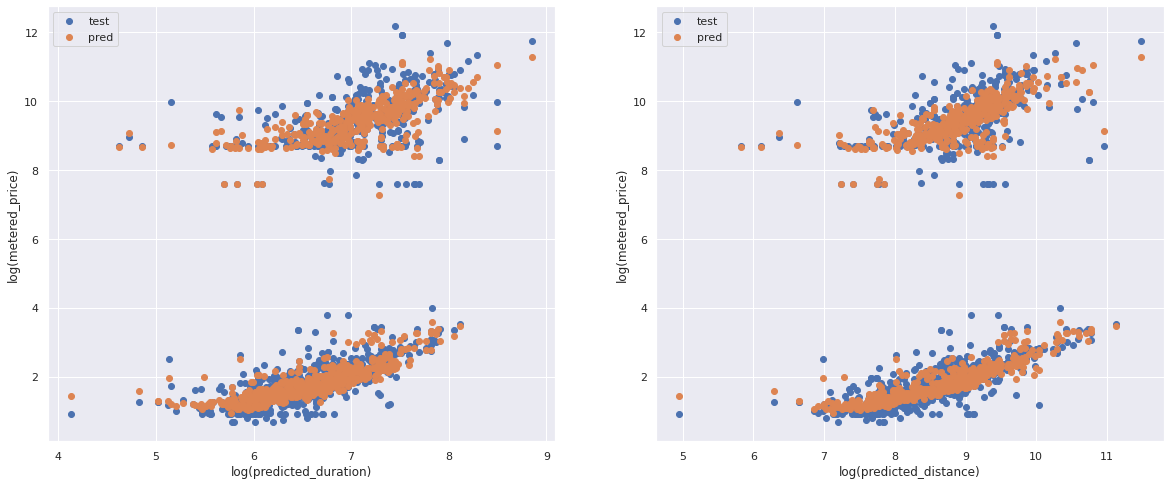

In [132]:
plot_results(X, y, y_pred)

## Random Forest

In [99]:
trips = download_dataset(DOWNLOAD_URL)
X, y = train_test_splitting.transform(trips)

In [110]:
steps = [
    ('poly', PolynomialFeatures(degree=2, include_bias=False, interaction_only=False)),
    ('scaler', StandardScaler()),
    ('rf', lgb.LGBMRegressor('rf', subsample=0.632, subsample_freq=1))
]
rf_pipe = Pipeline(steps)
# rf_pipe.fit(X['train'], y['train'])
# print_results(rf_pipe, X['test'], y['test'])

param_grid = {
#     'rf__bootstrap': [True],
    'rf__max_depth': [10, 20],
    'rf__n_estimators': [100, 200, 300]
}
grid_search = GridSearchCV(estimator=rf_pipe, param_grid=param_grid, cv=5, n_jobs=-1, verbose=1)
grid_search.fit(X['train'], y['train'])
print(grid_search.best_params_)
best_grid = grid_search.best_estimator_
y_pred = best_grid.predict(X['test'])
print_results(best_grid, X['test'], y['test'])

Fitting 5 folds for each of 6 candidates, totalling 30 fits
{'rf__max_depth': 10, 'rf__n_estimators': 200}
R^2 = 0.98626
RMSE = 0.44998
Baseline RMSE = 0.41872


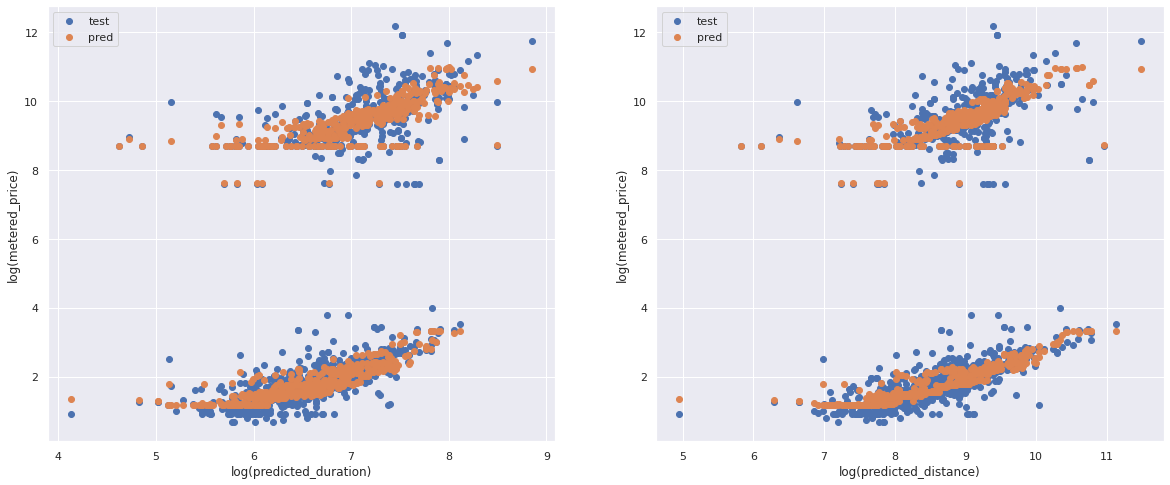

In [111]:
plot_results(X, y, y_pred)

# NN

In [97]:
class TripDataset(torch.utils.data.Dataset):
    '''
    Prepare the Boston dataset for regression
    '''

    def __init__(self, X, y):
        steps = [
            ('poly', PolynomialFeatures(degree=2, include_bias=False, interaction_only=False)),
            ('scaler', StandardScaler())
        ]
        self.ridge_pipe = Pipeline(steps)
        self.X = self.ridge_pipe.fit_transform(X)
        self.shape = self.X.shape
        
        if not torch.is_tensor(self.X) and not torch.is_tensor(y):
            self.X = torch.from_numpy(self.X)
            self.y = torch.from_numpy(y.values)

    def __len__(self):
        return len(self.X)

    def __getitem__(self, i):
        return self.X[i], self.y[i]
    
    def transform(self, X):
        transformed = self.ridge_pipe.transform(X)
        if not torch.is_tensor(transformed):
             transformed = torch.from_numpy(transformed)
        return transformed
      

class Net(nn.Module):
    '''
    Multilayer Perceptron for regression.
    '''
    def __init__(self, n_feature, n_hidden, n_output):
        super().__init__()
        self.layers = nn.Sequential(
            nn.Linear(n_feature, n_hidden),
            nn.ReLU(),
            nn.Linear(n_hidden, 3 * n_hidden),
            nn.ReLU(),
            nn.Linear(3 * n_hidden, n_hidden),
            nn.ReLU(),
            nn.Linear(n_hidden, n_output),
        )


    def forward(self, x):
        '''
          Forward pass
        '''
        return self.layers(x)

    
class RMSELoss(nn.Module):
    def __init__(self):
        super().__init__()
        self.mse = nn.MSELoss()
        
    def forward(self,yhat,y):
        return torch.sqrt(self.mse(yhat,y))
    
    
def run_epoch(trainloader, net, optimizer, loss_function):
    # Set current loss value
    current_loss = 0.0

    # Iterate over the DataLoader for training data
    for i, data in enumerate(trainloader, 0):
      
        # Get and prepare inputs
        inputs, targets = data
        inputs, targets = inputs.float(), targets.float()
        targets = targets.reshape((targets.shape[0], 1))
      
        # Zero the gradients
        optimizer.zero_grad()
      
        # Perform forward pass
        outputs = net(inputs)
      
        # Compute loss
        loss = loss_function(outputs, targets)

        # Perform backward pass
        loss.backward()

        # Perform optimization
        optimizer.step()
      
        # Print statistics
        current_loss += loss.item()
        if i % 10 == 0:
            print('Loss after mini-batch %5d: %.3f' % (i + 1, current_loss / 10))
            current_loss = 0.0

In [98]:
trips = download_dataset(DOWNLOAD_URL)
X, y = train_test_splitting.transform(trips)

In [99]:
# Set fixed random number seed
torch.manual_seed(42)

train_dataset = TripDataset(X['train'], y['train'])
# dataset = TripDataset(pd.DataFrame(X_train), pd.Series(y_train))
trainloader = torch.utils.data.DataLoader(train_dataset, batch_size=10, shuffle=True, num_workers=1)

# Initialize the MLP
net = Net(train_dataset.shape[1], 32, 1)
# net = Net(X_train.shape[1], 16, 1)

# Define the loss function and optimizer    
loss_function = RMSELoss()
optimizer = torch.optim.Adam(net.parameters(), lr=1e-3)
  
# Run the training loop
for epoch in range(10):
    
    # Print epoch
    print(f'Starting epoch {epoch+1}')
    
    run_epoch(trainloader, net, optimizer, loss_function)

# Process is complete.
print('Training process has finished.')

Starting epoch 1
Loss after mini-batch     1: 0.763
Loss after mini-batch    11: 6.091
Loss after mini-batch    21: 5.710
Loss after mini-batch    31: 4.290
Loss after mini-batch    41: 2.633
Loss after mini-batch    51: 1.642
Loss after mini-batch    61: 1.466
Loss after mini-batch    71: 0.958
Loss after mini-batch    81: 1.121
Loss after mini-batch    91: 0.939
Loss after mini-batch   101: 0.710
Loss after mini-batch   111: 0.766
Loss after mini-batch   121: 0.644
Loss after mini-batch   131: 0.723
Loss after mini-batch   141: 0.917
Loss after mini-batch   151: 0.734
Loss after mini-batch   161: 0.572
Loss after mini-batch   171: 0.703
Loss after mini-batch   181: 0.750
Loss after mini-batch   191: 0.484
Loss after mini-batch   201: 0.537
Loss after mini-batch   211: 0.536
Loss after mini-batch   221: 0.533
Loss after mini-batch   231: 0.721
Loss after mini-batch   241: 1.018
Loss after mini-batch   251: 0.613
Loss after mini-batch   261: 0.833
Loss after mini-batch   271: 0.653
Los

Loss after mini-batch   321: 0.494
Loss after mini-batch   331: 0.403
Loss after mini-batch   341: 0.392
Loss after mini-batch   351: 0.461
Loss after mini-batch   361: 0.582
Loss after mini-batch   371: 0.596
Loss after mini-batch   381: 0.513
Loss after mini-batch   391: 0.569
Starting epoch 7
Loss after mini-batch     1: 0.023
Loss after mini-batch    11: 0.457
Loss after mini-batch    21: 0.605
Loss after mini-batch    31: 0.416
Loss after mini-batch    41: 0.433
Loss after mini-batch    51: 0.422
Loss after mini-batch    61: 0.407
Loss after mini-batch    71: 0.373
Loss after mini-batch    81: 0.396
Loss after mini-batch    91: 0.454
Loss after mini-batch   101: 0.553
Loss after mini-batch   111: 0.512
Loss after mini-batch   121: 0.450
Loss after mini-batch   131: 0.403
Loss after mini-batch   141: 0.541
Loss after mini-batch   151: 0.351
Loss after mini-batch   161: 0.481
Loss after mini-batch   171: 0.371
Loss after mini-batch   181: 0.473
Loss after mini-batch   191: 0.485
Los

In [100]:
y_pred = net(train_dataset.transform(X['test']).float()).detach().numpy().flatten()

In [101]:
rmse(y['test'], y_pred)

0.4772796120514697

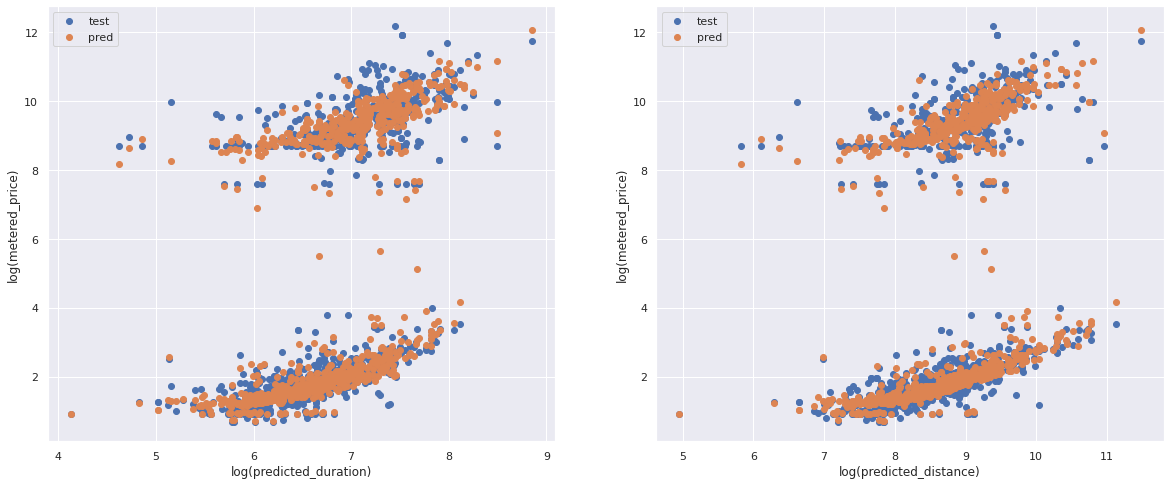

In [102]:
plot_results(X, y, y_pred)